In [1]:
%load_ext autotime
import warnings; warnings.filterwarnings('ignore')

In [2]:
import numpy as np
import pandas as pd
from causal import TCDF
import matplotlib.pyplot as plt

time: 774 ms


In [3]:
def get_proxy(freq = 'M', station = 'neum', norm=True, level = 200,\
              proxies = ['solar', 'qbo30', 'qbo50', 'mei', 'aao', 'hf', 'pv', 'aod'] ):
    prx = pd.read_csv('/home/pankaj/phd/tropo/antarctic/data/proxy/proxy2.index', sep='\s+', 
                 parse_dates = ['Date']).set_index('Date').resample(freq).mean()
    pv  = pd.read_csv('/home/pankaj/phd/tropo/antarctic/data/gph/' + str(level) + '.pv.csv',
                 sep = '\t', parse_dates=['time']).set_index('time')
    gph = pd.read_csv('/home/pankaj/phd/tropo/antarctic/data/gph/' + str(level) + '.gph.csv',
                 sep = '\t', parse_dates=['time']).set_index('time')
    hf  = pd.read_pickle('/home/pankaj/phd/tropo/antarctic/data/hfdata/ecmwf/ant.hf.' + str(level) +'.pkl')
    aodfile = '/home/pankaj/phd/tropo/antarctic/data/proxy/ant.aod.7918.pkl'
    prx['aod'] = pd.read_pickle(aodfile).resample(freq).mean()
    if station == 'arht':
        station = 'mcmu'
    prx['pv']  = pv[station].resample(freq).mean()
    prx['gph'] = gph[station].resample(freq).mean()
    prx['hf']  = hf.resample(freq).mean()
    if norm:
        prx = (prx-prx.mean()) / (prx.max()-prx.min())
    return prx[proxies] 

def get_data(station='neum', freq='MS', lev='tco', \
             ozfile='/home/pankaj/phd/tropo/antarctic/code/data/trop.col.pkl',\
             start = '1991-01-01', end = '2015-01-01', tph=1):
    if lev in ['tco', 'surface']:
        oz = pd.read_pickle(ozfile).resample(freq).mean()[station].dropna()
    else:
        oz = pd.read_pickle(ozfile).resample(freq).mean()[lev].dropna()
        oz.name = station + str(lev)
    
    if station=='neum':
        hgt = pd.read_csv('/home/pankaj/phd/tropo/antarctic/data/tropo_height/neum1', sep = '\t', \
                      parse_dates = True, index_col = 'Date').resample(freq).mean()
    elif station=='arht':
        hgt = pd.read_csv('/home/pankaj/phd/tropo/antarctic/data/tropo_height/mcmu', sep = '\t', \
                      parse_dates = True, index_col = 'Date').resample(freq).mean()
    else:
        hgt = pd.read_csv('/home/pankaj/phd/tropo/antarctic/data/tropo_height/' + station, sep = '\t', \
                      parse_dates = True, index_col = 'Date').resample(freq).mean()    
    hgt.columns = ['TPH']   
    
    reg = get_proxy(freq=freq, station=station, norm=False)
    if tph==1:
        data = pd.concat([oz, hgt, reg], axis=1)[start:end].dropna()
    elif tph==0:
        data = pd.concat([oz, reg], axis=1)[start:end].dropna() 
    else:
        data = pd.concat([hgt, reg], axis=1)[start:end].dropna()         
        
    data = (data-data.mean()) / (data.max()-data.min())
    #data = (data - data.shift(1)).dropna()
    return data

time: 4.02 ms


In [4]:
tmax  = 2
ofile = '/home/pankaj/phd/tropo/antarctic/code/data/surf.ozo.avg.pkl'
data  = get_data(station='neum', lev='surface', tph=0, ozfile=ofile)

time: 295 ms


In [5]:
discover = TCDF(data, significance=0.9)
causes, delays = discover.run(kernel_size=tmax, dilation_c=tmax, layers=3, epochs=1000)


 Target under consideration:  neum
Epoch:  1 [0%] 	Loss: 0.082100
Epoch: 500 [50%] 	Loss: 0.005245
Epoch: 1000 [100%] 	Loss: 0.004697
Potential Causes:  ['neum', 'pv']
Validated Causes:  ['neum', 'pv']
Delays: {('neum', 'neum'): 7, ('neum', 'pv'): 4}

 Target under consideration:  solar
Epoch:  1 [0%] 	Loss: 0.057931
Epoch: 500 [50%] 	Loss: 0.005054
Epoch: 1000 [100%] 	Loss: 0.004766
Potential Causes:  ['solar', 'neum']
Validated Causes:  ['solar']
Delays: {('solar', 'solar'): 1}

 Target under consideration:  qbo30
Epoch:  1 [0%] 	Loss: 0.086032
Epoch: 500 [50%] 	Loss: 0.002260
Epoch: 1000 [100%] 	Loss: 0.001641
Potential Causes:  ['qbo30', 'qbo50']
Validated Causes:  ['qbo30', 'qbo50']
Delays: {('qbo30', 'qbo30'): 1, ('qbo30', 'qbo50'): 5}

 Target under consideration:  qbo50
Epoch:  1 [0%] 	Loss: 0.071426
Epoch: 500 [50%] 	Loss: 0.006805
Epoch: 1000 [100%] 	Loss: 0.006615
Potential Causes:  ['qbo30']
Validated Causes:  ['qbo30']
Delays: {('qbo50', 'qbo30'): 7}

 Target under consid

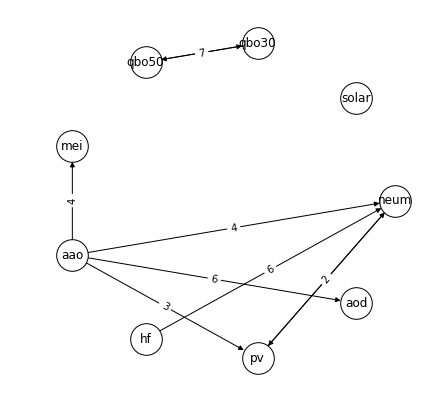

time: 232 ms


In [6]:
fig, ax = plt.subplots(1, 1, figsize=(7, 7))
discover.causal_graph(ax=ax)
plt.show()